<a href="https://colab.research.google.com/github/prachitshukla/DLFA-Kaggle/blob/development/M5_Mini_Hackathon_Classification_of_Emotions_of_Musical_Audio_Files_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:

To classify Happy or Sad Emotions in Musical Audio Files using deep learning techniques. Essentially, it is a binary classification framework.

### Problem Statement

To build/develop and implement a deep learning model for the classification of emotional tones between Happy or Sad Emotions in Musical Audio Files dataset.

At the end of this competition, you will be able to:

Load and extract audio features from wave files in the Musical Audio Files dataset using librosa, encompassing MFCC (Mel-Frequency Cepstral Coefficients), Mel spectrogram, and STFT (Short-time Fourier Transform).

Develop a deep learning model utilizing either the Keras or PyTorch deep learning libraries.


### Description:

Dataset Description: The original dataset contains 7 classes but this is just a subset of the original dataset which contains 2 classes. The audio files in the dataset were already preprocessed by converting them into smaller chunks of equal size. All music were divided into 10 seconds smaller chunks using FFMPEG.

The chunks of the same song have the equally spaced names like : Happy20001-Happy20016(Same song) The last two digits resembles the chunk number while the first three digits are the ID of the original song which is provided as the GroupID. The two classes are: 1.)Happy and 2.)Sad


## Grading = 10 Marks

Here is a handy link to Kaggle's competition documentation (https://www.kaggle.com/docs/competitions), which includes, among other things, instructions on submitting predictions (https://www.kaggle.com/docs/competitions#making-a-submission).

### Instructions for downloading train and test data are as follows:

### 1. Create an API key in Kaggle.

To do this, go to the competition site on Kaggle at (https://www.kaggle.com/t/058bf9c00aeb4e30967d10d11e2441ae) and click on user then click on your profile as shown below. Click Account.

![alt text](https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/Capture-NLP.PNG)

### 2. Next, scroll down to the API access section and click on **Create New Token** to download an API key (kaggle.json).

![alt text](https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/Capture-NLP_1.PNG)

### 3. Upload your kaggle.json file using the following snippet in a code cell:



In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kiansh21","key":"224b5347a022995a7f669f23b2dad684"}'}

In [2]:
#If successfully uploaded in the above step, the 'ls' command here should display the kaggle.json file.
%ls

kaggle.json  sample_data/


### 4. Install the Kaggle API using the following command


In [ ]:
!pip install -U -q kaggle==1.5.8

### 5. Move the kaggle.json file into ~/.kaggle, which is where the API client expects your token to be located:



In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
#Execute the following command to verify whether the kaggle.json is stored in the appropriate location: ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [6]:
!chmod 600 /root/.kaggle/kaggle.json #run this command to ensure your Kaggle API token is secure on colab

### 6. Now download the Test Data from Kaggle

**NOTE: If you get a '403 - Not Found' error after running the cell below, it is most likely that the user (whose kaggle.json is uploaded above) has not 'accepted' the rules of the competition and therefore has 'not joined' the competition.**

If you encounter **401-unauthorised** download latest **kaggle.json** by repeating steps 1 & 2

In [ ]:
#If you get a forbidden link, you have most likely not joined the competition.
!kaggle competitions download -c classification-of-emotions-of-musical-audio-files
!unzip classification-of-emotions-of-musical-audio-files.zip

### YOUR CODING STARTS FROM HERE

### Import Neccesary Packages

In [ ]:
# YOUR CODE HERE
! pip install librosa

In [42]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import librosa
import librosa.display
from pathlib import Path
from matplotlib import pyplot as plt
import torch.nn.functional as F


import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import random


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoProcessor, AutoModelForAudioClassification
import torchaudio

from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


### **Stage 1:** Load the Train data audio files (1 point)




In [10]:
#Load from Train Set
data_path = './Train/Train'

def get_files(path, extension='.wav'):
    return list(path.rglob(f'*{extension}'))


label_id = {"01": "happy",
            '02': "sad"
           }

# Get all files from the ravdess data folders
all_files = get_files(Path(data_path))
print(len(all_files))




1873


#### Play the sample audio

In [11]:
import IPython.display as ipd
ipd.Audio(filename=os.path.join(os.getcwd(), all_files[1872]), rate=48000)

### **Stage 2:** Data Exploration and Visualization (1 point)


*  Find count of each label and plot bar graph



<class 'list'>
1873
{'file': PosixPath('Train/Train/Happy/Happy38916.wav'), 'label': 'happy'}


<Axes: xlabel='label', ylabel='count'>

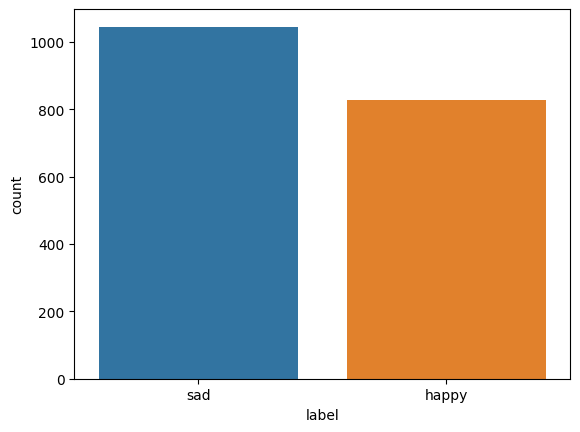

In [12]:
# YOUR CODE HERE
labels = list(map(lambda f: {"file": f, "label": "happy" if "happy" in os.path.basename(f).lower() else "sad"}, all_files))
print(type(labels))
print(len(labels))
print(labels[1872])


df_labels = pd.DataFrame(labels)
df_labels.head()
df_labels.tail()

sns.countplot(data=df_labels, x="label", hue='label')
#plt.show()


#### Visualize sample audio signal using librosa

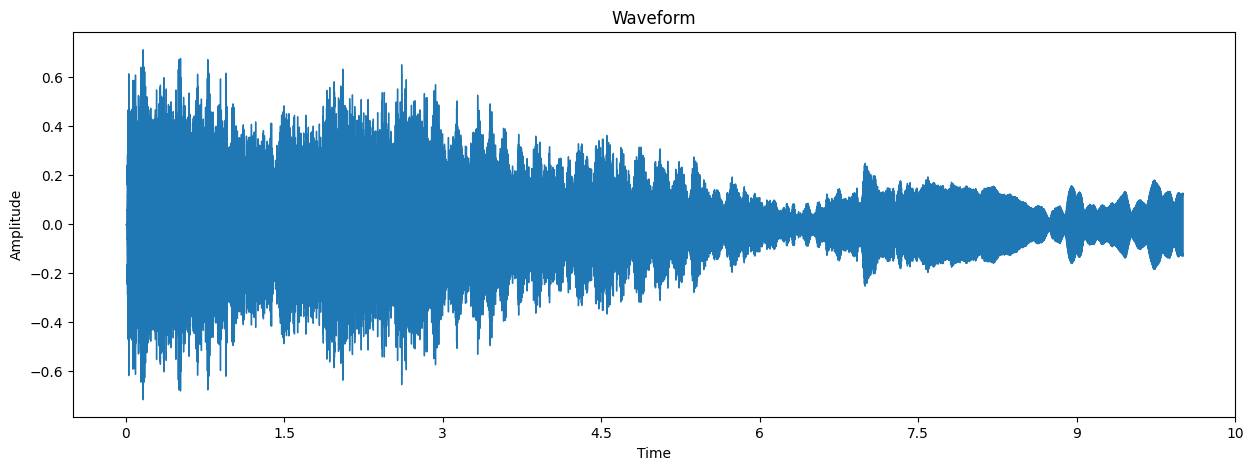

In [13]:
# YOUR CODE HERE
sample_audio_path = os.path.join(os.getcwd(), all_files[1872])

# librosa is used for analyzing and extracting features of an audio signal
data, sampling_rate = librosa.load(sample_audio_path)
plt.figure(figsize=(15, 5))


# librosa.display.waveshow is used to plot waveform of amplitude vs time
librosa.display.waveshow(data, sr=sampling_rate)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

### **Stage 3:** Feature extraction (2 points)


In [14]:
#suffle array values
print(all_files)
random.shuffle(all_files)
print('*'.center(80,'*'))
print(all_files)

[PosixPath('Train/Train/Sad/Sad12919.wav'), PosixPath('Train/Train/Sad/Sad12920.wav'), PosixPath('Train/Train/Sad/Sad39709.wav'), PosixPath('Train/Train/Sad/Sad25901.wav'), PosixPath('Train/Train/Sad/Sad33112.wav'), PosixPath('Train/Train/Sad/Sad33107.wav'), PosixPath('Train/Train/Sad/Sad19508.wav'), PosixPath('Train/Train/Sad/Sad23509.wav'), PosixPath('Train/Train/Sad/Sad12926.wav'), PosixPath('Train/Train/Sad/Sad22206.wav'), PosixPath('Train/Train/Sad/Sad19505.wav'), PosixPath('Train/Train/Sad/Sad38603.wav'), PosixPath('Train/Train/Sad/Sad15204.wav'), PosixPath('Train/Train/Sad/Sad25718.wav'), PosixPath('Train/Train/Sad/Sad38819.wav'), PosixPath('Train/Train/Sad/Sad30102.wav'), PosixPath('Train/Train/Sad/Sad19305.wav'), PosixPath('Train/Train/Sad/Sad35015.wav'), PosixPath('Train/Train/Sad/Sad36012.wav'), PosixPath('Train/Train/Sad/Sad22221.wav'), PosixPath('Train/Train/Sad/Sad19304.wav'), PosixPath('Train/Train/Sad/Sad16010.wav'), PosixPath('Train/Train/Sad/Sad15803.wav'), PosixPath(

In [20]:
# Parameters
SAMPLE_RATE = 16000
MAX_LEN = 5  # seconds
N_MFCC = 40

def extract_mfcc(file_path, n_mfcc=13):
    data, sampling_rate = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
    mfcc = librosa.util.fix_length(mfcc, size=MAX_LEN * 100, axis=1)

    return mfcc

In [88]:
import os

def load_dataset(root_dir):
    features_list = []
    labels = []
    for dir in os.listdir(root_dir):
      for filename in os.listdir(os.path.join(root_dir, dir)):
          if filename.endswith(".wav"):
              print(filename)
              file_path = os.path.join(root_dir, dir, filename)
              mfcc_features = extract_mfcc(file_path)

              # Label based on filename (basic example)
              if 'happy' in filename.lower():
                label = 'happy'
              elif 'sad' in filename.lower():
                label = 'sad'
              else:
                continue  # skip unlabeled files

              features_list.append(mfcc_features)
              labels.append(label)
    return np.array(features_list), np.array(labels)

root_dir = "./Train/Train/"
feature_list_temp, labels_temp = load_dataset(root_dir)

print(len(feature_list_temp), len(labels_temp))

Sad12919.wav
Sad12920.wav
Sad39709.wav
Sad25901.wav
Sad33112.wav
Sad33107.wav
Sad19508.wav
Sad23509.wav
Sad12926.wav
Sad22206.wav
Sad19505.wav
Sad38603.wav
Sad15204.wav
Sad25718.wav
Sad38819.wav
Sad30102.wav
Sad19305.wav
Sad35015.wav
Sad36012.wav
Sad22221.wav
Sad19304.wav
Sad16010.wav
Sad15803.wav
Sad30008.wav
Sad33410.wav
Sad30108.wav
Sad37605.wav
Sad25723.wav
Sad19413.wav
Sad19803.wav
Sad19606.wav
Sad35215.wav
Sad44402.wav
Sad19414.wav
Sad30010.wav
Sad38817.wav
Sad30113.wav
Sad44413.wav
Sad22219.wav
Sad33103.wav
Sad36015.wav
Sad30105.wav
Sad11609.wav
Sad14416.wav
Sad16201.wav
Sad19300.wav
Sad14109.wav
Sad12937.wav
Sad23515.wav
Sad17412.wav
Sad19801.wav
Sad30611.wav
Sad30019.wav
Sad14101.wav
Sad40503.wav
Sad38609.wav
Sad35206.wav
Sad45902.wav
Sad31713.wav
Sad25922.wav
Sad23518.wav
Sad33400.wav
Sad38804.wav
Sad25921.wav
Sad30002.wav
Sad35004.wav
Sad14422.wav
Sad42210.wav
Sad34116.wav
Sad33110.wav
Sad25918.wav
Sad19310.wav
Sad19613.wav
Sad19405.wav
Sad34106.wav
Sad39906.wav
Sad31206.wav

<ipython-input-20-3420901200>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(


Sad17411.wav
Sad17424.wav
Sad39708.wav
Sad44407.wav
Sad40814.wav
Sad16200.wav
Sad31722.wav
Sad19603.wav
Sad21805.wav
Sad35205.wav
Sad31205.wav
Sad35001.wav
Sad39710.wav
Sad25408.wav
Sad36913.wav
Sad35010.wav
Sad23507.wav
Sad44403.wav
Sad19607.wav
Sad16209.wav
Sad30016.wav
Sad35201.wav
Sad33402.wav
Sad30617.wav
Sad14405.wav
Sad31221.wav
Sad19818.wav
Sad12912.wav
Sad30114.wav
Sad30015.wav
Sad38604.wav
Sad19809.wav
Sad19513.wav
Sad21803.wav
Sad15818.wav
Sad19401.wav
Sad35005.wav
Sad31724.wav
Sad25928.wav
Sad30604.wav
Sad19806.wav
Sad30818.wav
Sad39712.wav
Sad12908.wav
Sad14104.wav
Sad30804.wav
Sad40817.wav
Sad25402.wav
Sad12929.wav
Sad21837.wav
Sad14412.wav
Sad34117.wav
Sad12910.wav
Sad37601.wav
Sad36004.wav
Sad35214.wav
Sad15802.wav
Sad22510.wav
Sad19812.wav
Sad30600.wav
Sad38605.wav
Sad25915.wav
Sad16015.wav
Sad30801.wav
Sad35204.wav
Sad25721.wav
Sad30810.wav
Sad11607.wav
Sad17414.wav
Sad19518.wav
Sad16221.wav
Sad30003.wav
Sad39904.wav
Sad22523.wav
Sad23911.wav
Sad31200.wav
Sad22005.wav

<ipython-input-20-3420901200>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Happy36710.wav
Happy21908.wav
Happy35710.wav
Happy41503.wav
Happy32710.wav
Happy26509.wav
Happy32709.wav
Happy27911.wav
Happy21402.wav
Happy18605.wav
Happy25321.wav
Happy43410.wav
Happy22015.wav
Happy10204.wav
Happy15208.wav
Happy15202.wav
Happy33609.wav
Happy22002.wav
Happy43419.wav
Happy31403.wav
Happy18608.wav
Happy15807.wav
Happy18103.wav
Happy17818.wav
Happy39100.wav
Happy11107.wav
Happy36712.wav
Happy25307.wav
Happy11109.wav
Happy33407.wav
Happy15815.wav
Happy26520.wav
Happy26202.wav
Happy38902.wav
Happy38911.wav
Happy17202.wav
Happy17817.wav
Happy13614.wav
Happy37410.wav
Happy38918.wav
Happy33414.wav
Happy32715.wav
Happy36307.wav
Happy29910.wav
Happy23107.wav
Happy33411.wav
Happy39105.wav
Happy33405.wav
Happy28302.wav
Happy36517.wav
Happy32703.wav
Happy14400.wav
Happy38210.wav
Happy25315.wav
Happy28319.wav
Happy31408.wav
Happy29914.wav
Happy13608.wav
Happy19701.wav
Happy13606.wav
Happy19719.wav
Happy35707.wav
Happy14001.wav
Happy14413.wav
Happy28304.wav
Happy14009.wav
Happy21904

In [89]:
print(len(labels_temp))
print(feature_list_temp)

1873
[[[-2.98084564e+02 -2.02641068e+02 -1.77389175e+02 ... -2.55805740e+02
   -2.68667023e+02 -2.76627411e+02]
  [ 1.76741333e+02  2.08325119e+02  2.11739166e+02 ...  1.97698318e+02
    1.98250290e+02  2.00100586e+02]
  [-7.26835155e+00 -3.49641571e+01 -4.09070587e+01 ... -2.11239662e+01
   -1.16523438e+01 -8.24154091e+00]
  ...
  [-1.66565132e+01 -1.49060497e+01 -1.48948050e+01 ...  2.47718349e-01
   -4.12659788e+00 -5.29519033e+00]
  [-4.13824844e+00 -2.37197566e+00 -6.18413353e+00 ... -8.26407719e+00
   -5.85464430e+00 -3.03596854e-01]
  [-4.99779034e+00 -1.13271008e+01 -1.58587351e+01 ... -1.27391129e+01
   -1.05322170e+01  1.32790208e+00]]

 [[-5.81611267e+02 -5.27320801e+02 -5.11856171e+02 ... -5.58929504e+02
   -5.58590271e+02 -5.59526306e+02]
  [ 1.01642433e+02  1.48440277e+02  1.62110687e+02 ...  1.19568542e+02
    1.19949234e+02  1.17952965e+02]
  [ 2.57864761e+01  2.34986897e+01  2.50686779e+01 ...  2.45476418e+01
    2.45999718e+01  2.16534653e+01]
  ...
  [ 2.51636467e+01

### **Stage 4:** Train the model  (4 points)


In [90]:
root_dir = "./Train/Train/"
data_array, label_list = load_dataset(root_dir)

print(len(data_array))
print(len(label_list))

Sad12919.wav
Sad12920.wav
Sad39709.wav
Sad25901.wav
Sad33112.wav
Sad33107.wav
Sad19508.wav
Sad23509.wav
Sad12926.wav
Sad22206.wav
Sad19505.wav
Sad38603.wav
Sad15204.wav
Sad25718.wav
Sad38819.wav
Sad30102.wav
Sad19305.wav
Sad35015.wav
Sad36012.wav
Sad22221.wav
Sad19304.wav
Sad16010.wav
Sad15803.wav
Sad30008.wav
Sad33410.wav
Sad30108.wav
Sad37605.wav
Sad25723.wav
Sad19413.wav
Sad19803.wav
Sad19606.wav
Sad35215.wav
Sad44402.wav
Sad19414.wav
Sad30010.wav
Sad38817.wav
Sad30113.wav
Sad44413.wav
Sad22219.wav
Sad33103.wav
Sad36015.wav
Sad30105.wav
Sad11609.wav
Sad14416.wav
Sad16201.wav
Sad19300.wav
Sad14109.wav
Sad12937.wav
Sad23515.wav
Sad17412.wav
Sad19801.wav
Sad30611.wav
Sad30019.wav
Sad14101.wav
Sad40503.wav
Sad38609.wav
Sad35206.wav
Sad45902.wav
Sad31713.wav
Sad25922.wav
Sad23518.wav
Sad33400.wav
Sad38804.wav
Sad25921.wav
Sad30002.wav
Sad35004.wav
Sad14422.wav
Sad42210.wav
Sad34116.wav
Sad33110.wav
Sad25918.wav
Sad19310.wav
Sad19613.wav
Sad19405.wav
Sad34106.wav
Sad39906.wav
Sad31206.wav

<ipython-input-20-3420901200>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(


Sad17424.wav
Sad39708.wav
Sad44407.wav
Sad40814.wav
Sad16200.wav
Sad31722.wav
Sad19603.wav
Sad21805.wav
Sad35205.wav
Sad31205.wav
Sad35001.wav
Sad39710.wav
Sad25408.wav
Sad36913.wav
Sad35010.wav
Sad23507.wav
Sad44403.wav
Sad19607.wav
Sad16209.wav
Sad30016.wav
Sad35201.wav
Sad33402.wav
Sad30617.wav
Sad14405.wav
Sad31221.wav
Sad19818.wav
Sad12912.wav
Sad30114.wav
Sad30015.wav
Sad38604.wav
Sad19809.wav
Sad19513.wav
Sad21803.wav
Sad15818.wav
Sad19401.wav
Sad35005.wav
Sad31724.wav
Sad25928.wav
Sad30604.wav
Sad19806.wav
Sad30818.wav
Sad39712.wav
Sad12908.wav
Sad14104.wav
Sad30804.wav
Sad40817.wav
Sad25402.wav
Sad12929.wav
Sad21837.wav
Sad14412.wav
Sad34117.wav
Sad12910.wav
Sad37601.wav
Sad36004.wav
Sad35214.wav
Sad15802.wav
Sad22510.wav
Sad19812.wav
Sad30600.wav
Sad38605.wav
Sad25915.wav
Sad16015.wav
Sad30801.wav
Sad35204.wav
Sad25721.wav
Sad30810.wav
Sad11607.wav
Sad17414.wav
Sad19518.wav
Sad16221.wav
Sad30003.wav
Sad39904.wav
Sad22523.wav
Sad23911.wav
Sad31200.wav
Sad22005.wav
Sad11608.wav

<ipython-input-20-3420901200>:7: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sampling_rate = librosa.load(file_path, sr=None)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Happy21908.wav
Happy35710.wav
Happy41503.wav
Happy32710.wav
Happy26509.wav
Happy32709.wav
Happy27911.wav
Happy21402.wav
Happy18605.wav
Happy25321.wav
Happy43410.wav
Happy22015.wav
Happy10204.wav
Happy15208.wav
Happy15202.wav
Happy33609.wav
Happy22002.wav
Happy43419.wav
Happy31403.wav
Happy18608.wav
Happy15807.wav
Happy18103.wav
Happy17818.wav
Happy39100.wav
Happy11107.wav
Happy36712.wav
Happy25307.wav
Happy11109.wav
Happy33407.wav
Happy15815.wav
Happy26520.wav
Happy26202.wav
Happy38902.wav
Happy38911.wav
Happy17202.wav
Happy17817.wav
Happy13614.wav
Happy37410.wav
Happy38918.wav
Happy33414.wav
Happy32715.wav
Happy36307.wav
Happy29910.wav
Happy23107.wav
Happy33411.wav
Happy39105.wav
Happy33405.wav
Happy28302.wav
Happy36517.wav
Happy32703.wav
Happy14400.wav
Happy38210.wav
Happy25315.wav
Happy28319.wav
Happy31408.wav
Happy29914.wav
Happy13608.wav
Happy19701.wav
Happy13606.wav
Happy19719.wav
Happy35707.wav
Happy14001.wav
Happy14413.wav
Happy28304.wav
Happy14009.wav
Happy21904.wav
Happy37407

In [92]:
lable_encoder = LabelEncoder()
label_encoded = lable_encoder.fit_transform(label_list)
print(label_list)
print(label_encoded)

['sad' 'sad' 'sad' ... 'happy' 'happy' 'happy']
[1 1 1 ... 0 0 0]


In [46]:
X_train, X_test, y_train, y_test = train_test_split(data_array, label_encoded, test_size=0.2, random_state=42)
y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

In [38]:
# Reshape input for CNN [samples, height, width, channels]
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [43]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(y_train_enc.shape[1], activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 498, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 249, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 249, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 247, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 123, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 123, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,007,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026,818 (3.92 MB)

 Trainable params: 1,026,818 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model.fit(X_train, y_train_enc, epochs=20, batch_size=32, validation_data=(X_test, y_test_enc))


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 0.9360 - loss: 0.1604 - val_accuracy: 0.7040 - val_loss: 1.3390
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.9238 - loss: 0.1851 - val_accuracy: 0.7013 - val_loss: 1.4011
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.9309 - loss: 0.1690 - val_accuracy: 0.6960 - val_loss: 1.2465
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.9365 - loss: 0.1632 - val_accuracy: 0.7120 - val_loss: 1.2456
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 0.9188 - loss: 0.1843 - val_accuracy: 0.6907 - val_loss: 1.2951
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9334 - loss: 0.1609 - val_accuracy: 0.7067 - val_loss: 1.3443
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.9371 - loss: 0.1729 - val_accuracy: 0.7093 - val_loss: 1.3101
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.9303 - loss: 0.1730 - val_accuracy

In [66]:
loss, acc = model.evaluate(X_test, y_test_enc)
print(f"Test Accuracy: {acc:.2f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7279 - loss: 1.1602
Test Accuracy: 0.70


In [96]:
#Retain with full dataset
X_train_full = data_array
y_train_full = label_encoded
y_train_full_enc = to_categorical(y_train)
X_train_full = X_train_full[..., np.newaxis]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model.fit(X_train_full, y_train_full_enc, epochs=20, batch_size=128)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 11, 498, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 5, 249, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 249, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 247, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 123, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 123, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,007,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,026,818 (3.92 MB)

 Trainable params: 1,026,818 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 728ms/step - accuracy: 0.9338 - loss: 0.1683
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 757ms/step - accuracy: 0.9394 - loss: 0.1507
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 690ms/step - accuracy: 0.9255 - loss: 0.1694
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9362 - loss: 0.1411
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 719ms/step - accuracy: 0.9408 - loss: 0.1380
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 719ms/step - accuracy: 0.9295 - loss: 0.1663
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 657ms/step - accuracy: 0.9326 - loss: 0.1338
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 716ms/step - accuracy: 0.9381 - loss: 0.1441
Epoch 9/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 718ms/step - accuracy: 0.9503 - loss: 0.1352
Epoch 10/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 643ms/step - accuracy: 0.9382 - loss: 0.1361
Epoch 11/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step - accuracy: 0.9499 - loss: 0.1137
Epoch 12/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 11

### **Stage 5:** Kaggle Testset predictions (2 points)



*   Load the test set and extract the features of the .wav files
*   Using the trained model get the predicions on the test set
*   Finally, upload your predictions to the kaggle



In [97]:
#Prepaire Test Dataset

file_ids=[]
test_features_list = []

def extract_features_from_test_folder(folder_path):
    """Extracts MFCC features from all .wav files in the specified folder and its subfolders."""
    for dir in os.listdir(folder_path):
      dir_path = os.path.join(folder_path, dir)
      # Ensure it's a directory before listing
      if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            if filename.endswith(".wav"):
                  file_ids.append(filename)
                  file_path = os.path.join(dir_path, filename)

                  # Extract features
                  mfcc = extract_mfcc(file_path)
                  test_features_list.append(mfcc)

test_data_path = './Test/'

# Extract features from all test files
extract_features_from_test_folder(test_data_path)

# Convert the list of features into a single numpy array
data_array_test = np.array(test_features_list)

# Reshape the test data for CNN prediction [samples, height, width, channels]
# The reshape is done here once for the entire test dataset
data_array_test = data_array_test[..., np.newaxis]


print(f"Number of test files processed: {len(data_array_test)}")
print(f"Shape of test feature array: {data_array_test.shape}")
print(f"Number of file_ids collected: {len(file_ids)}")

# Now perform prediction on the entire test dataset
# This replaces the model.predict call inside the loop
y_pred_test = model.predict(data_array_test)

print(type(y_pred_test))
print(y_pred_test.shape) # Check the shape of the predictions

Number of test files processed: 253
Shape of test feature array: (253, 13, 500, 1)
Number of file_ids collected: 253


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
<class 'numpy.ndarray'>
(253, 2)


In [ ]:
print(type(y_pred_test))
print(y_pred_test)

In [98]:
# Get the max values from prediction

# From the max values decode the sentiments
predicted_classes = np.argmax(y_pred_test, axis=1)
print(predicted_classes)

# Assuming the LabelEncoder's classes are correctly ordered, manually map to strings
# lable_encoder.classes_ should be an array like ['happy', 'sad']
predicted_test_sentiments_str = lable_encoder.inverse_transform(predicted_classes)
print(predicted_test_sentiments_str)


predicted_test_sentiments= np.array([sentiment.capitalize() for sentiment in predicted_test_sentiments_str])

print("Predicted sentiments (first 10):", predicted_test_sentiments[:10])

[1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 0 1
 1 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1
 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1
 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1
 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1]
['sad' 'sad' 'happy' 'sad' 'sad' 'sad' 'sad' 'happy' 'sad' 'sad' 'happy'
 'happy' 'sad' 'sad' 'sad' 'sad' 'sad' 'happy' 'sad' 'sad' 'sad' 'sad'
 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'happy' 'happy' 'happy'
 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'happy' 'sad' 'sad' 'sad' 'sad' 'sad'
 'sad' 'sad' 'sad' 'sad' 'sad' 'sad' 'happy' 'sad' 'sad' 'sad' 'happy'
 'happy' 'sad' 'sad' 'sad' 'happy' 'happy' 'happy' 'sad' 'happy' 'sad'
 'sad' 'sad' 'sad' 'happy' 'happy' 'happy' 'happy' '

In [99]:
# Create a dataframe and add the Test_Id and predicted sentiment text to it
output_df = pd.DataFrame({'File Name': file_ids, 'Target': predicted_test_sentiments})

output_df.sort_values(by='File Name',  key=lambda x: x.str.extract('(\d+)').astype(int)[0], inplace=True)
print(output_df.head(100))
# Write to CSV file
output_df.to_csv('sentiment_predictions_sorted_full_CNN.csv', index=False)

    File Name Target
52      1.wav    Sad
210     2.wav    Sad
197     3.wav    Sad
196     4.wav    Sad
84      5.wav    Sad
..        ...    ...
117    96.wav  Happy
30     97.wav  Happy
218    98.wav  Happy
78     99.wav  Happy
61    100.wav  Happy

[100 rows x 2 columns]
